## Reference

This code has been adapted from the github:
https://github.com/mml-book/mml-book.github.io




In [3]:
import numpy as np
import timeit
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# from ipywidgets import interact
from sklearn.datasets import fetch_openml

# Load images

In [4]:
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
plt.figure(figsize=(4,4))
# plt.imshow(images[0].reshape(28,28), cmap='gray');
images = images.to_numpy()
labels = labels.to_numpy()


<Figure size 288x288 with 0 Axes>

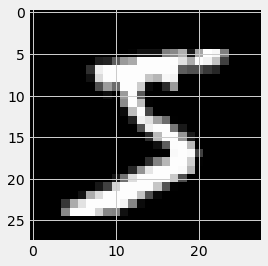

In [5]:
# plot an MNIST image
plt.imshow(images[0].reshape(28,28), cmap='gray');
# plt.show()


In [6]:
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std

def mean_shift(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean): tuple of ndarray, Xbar is the mean shifted
    
    """
    mu = np.mean(X, axis=0)

    Xbar = ((X-mu))
    return Xbar, mu

def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    eigvals, eigvecs = np.linalg.eig(S)
    k = np.argsort(eigvals)[::-1]
    return eigvals[k], eigvecs[:,k]

In [7]:
# copy images to X
X = images[:]
# Xbar, mu, std = normalize(X)
Xbar, mu = mean_shift(X)
S = 1.0/len(X) * np.dot(Xbar.T, Xbar)
eigvals, eigvecs = eig(S)
eigvals.shape



(784,)

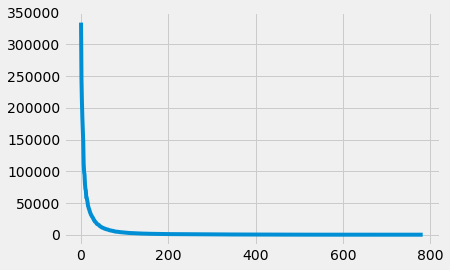

In [8]:
# Plot eigenvalues. Since the eig function sorts eigenvalues in descending order, we should see a decaying plot
plt.plot(eigvals)

In [9]:
eigvals[:10]
# std.shape

array([334289.28578913, 245429.92095246, 210927.34129493, 185334.70864258,
       167689.17681018, 147668.18704742, 112443.53257154,  99113.96735172,
        94611.18715419,  80334.80928116])

In [10]:
eigvecs.shape

(784, 784)

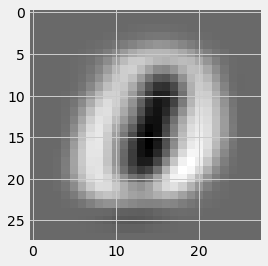

In [17]:
principal_img = eigvecs
plot_img = principal_img[:,0]
plt.imshow(plot_img.reshape(28,28), cmap='gray');

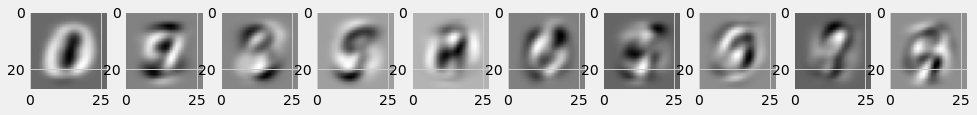

In [22]:
principal_img = eigvecs
rows =1
cols =10
fig, axes = plt.subplots(ncols=cols, figsize=(15,15))

for i in range(rows):
    for j in range(cols):        
#         if img_count < len(images):
        axes[j].imshow((principal_img[:,j]).reshape(28,28), cmap='gray')
#         img_count+=1

In [24]:
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    return (B @ np.linalg.inv(B.T @ B) @ B.T)

def reconstruct_with_comp(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    # first perform normalization on the digits so that they have zero mean and unit variance
    # Then compute the data covariance matrix S
    S = 1.0/len(X) * np.dot(X.T, X)

    # Next find eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eig(S)

    # find indices for the largest eigenvalues, use them to sort the eigenvalues and 
    # corresponding eigenvectors. Take a look at the documenation fo `np.argsort` 
    # (https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html),
    # which might be useful
    eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]

    # dimensionality reduction of the original data
    B = np.real(eig_vecs)
    # Z = X.T.dot(W)
    # reconstruct the images from the lower dimensional representation
    reconst = (projection_matrix(B) @ X.T)
    return reconst.T

In [23]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [47]:
loss = []
reconstructions = []
N_comp =10
sampling_f = 20

# iterate over different numbers of principal components, and compute the MSE
for num_component in range(1, sampling_f*N_comp+1, sampling_f):
    reconst = reconstruct_with_comp(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

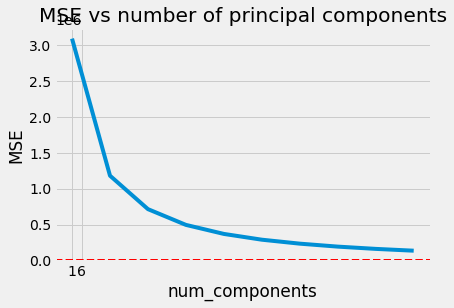

In [48]:
N_comp =10
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(N_comp, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, N_comp, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

In [49]:
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)
    
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

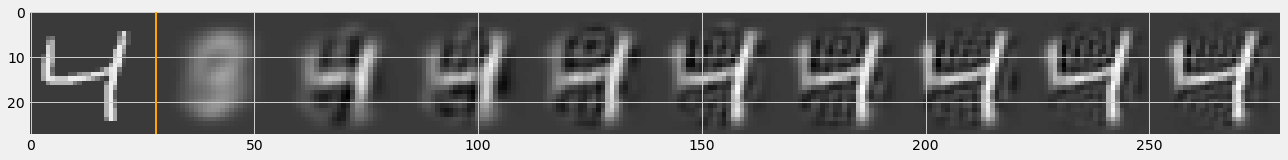

In [50]:
show_num_components_reconst(2)

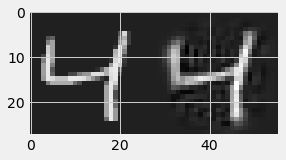

In [51]:
show_pca_digits(2)